# Predicting Seattle Collisions

In [7]:
# importing libraries
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import functions as fn
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

%matplotlib inline

## Loading the dataset

In [11]:
# loading the data set
filepath = 'data/'
df = pd.read_csv(filepath + 'Collisions.csv')
weather = pd.read_csv(filepath + 'weather.csv')
df = df[pd.to_datetime(df.INCDATE).dt.year >= 2008]

We have a big dataset of over 200k collisions over the past 14 years. Since we are predicting collisions per day, we filtered the data for last 10 years to capture the recent trends in the modeling.

In categorizing some of the data, we thought it would be useful in separating the lighting conditions into day and night because we found some patterns occur depending on different lighting conditions. We initially thought that this sinusoidal pattern from the EDA represented a trend in when collisions occur, but upon further exploring through the data we found it weird that temperature might be correlating with the collision occurrences. We realized that there could be a confounding variable. Both temperature and collisions that occur in the day and night are correlated with the number of hours of daylight that occur throughout the year. It makes sense that as winter approaches, the number of hours in daylight decreases. Lower hours of day, means there is less time for collisions in the day and drops in temperature due to less exposure from the sun. But we still found that this information might represent useful information so we grouped them to ‘Day’ and ‘Night’.

## Data Prep: Adding Features

In [12]:
# Adding new columns to the data

df['dayofweek'] = pd.to_datetime(df.INCDATE).dt.dayofweek
df['weekofyear'] = pd.to_datetime(df.INCDATE).dt.weekofyear
df['month'] = pd.to_datetime(df.INCDATE).dt.month
df = df.rename(columns={'INCDATE': 'DATE'})
df['LIGHTCOND'] = df.LIGHTCOND.replace('Dark - No Street Lights', 'Night')
df['LIGHTCOND'] = df.LIGHTCOND.replace('Dark - Street Lights Off', 'Night')
df['LIGHTCOND'] = df.LIGHTCOND.replace('Dark - Street Lights On', 'Night')
df['LIGHTCOND'] = df.LIGHTCOND.replace('Dawn', 'Day')
df['LIGHTCOND'] = df.LIGHTCOND.replace('Daylight', 'Day')
df['LIGHTCOND'] = df.LIGHTCOND.replace('Dusk', 'Day')
df = df.loc[df['LIGHTCOND'].isin(['Day','Night'])]

Since there could be seasonal differences in when collisions occur, we decided to group the information based on the date information such as weekofyear, month and day of week.

In [13]:
# Grouping the data using date
df = df.groupby(['DATE','weekofyear','dayofweek','month', 'LIGHTCOND']).size().reset_index(name='collisions')
df['DATE'] = pd.to_datetime(df.DATE)

The weather data might also be important in determining when collisions occur such as precipitation (rain) and temperature so we included these in our model as well.

In [14]:
# Merge weather with the collision data
weather['DATE'] = pd.to_datetime(weather.DATE)
df = pd.merge(df, weather[['DATE','PRCP','TMAX','TMIN']])

In [15]:
# Adding column to get the daylight hours
df['daylight_hrs'] = list(map(fn.hours_of_daylight, df.DATE))

## One Hot Encoding

In [16]:
# Encoding the data using One Hot Encoding
df_dum = pd.get_dummies(df, columns=['weekofyear','dayofweek','month','LIGHTCOND'])
df_dum = df_dum[df_dum.columns[2:80]]

In [17]:
df_dum.head()

,PRCP,TMAX,TMIN,daylight_hrs,weekofyear_1,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,LIGHTCOND_Day,LIGHTCOND_Night
0,0.00,47,41,8.290187,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.00,47,41,8.290187,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.40,46,37,8.304641,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.40,46,37,8.304641,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.19,49,40,8.320386,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
# splitting the data into Training and Testing
train_features, test_features, train_outcomes, test_outcomes = train_test_split(
    df_dum,
    df['collisions'],
    test_size = 0.3,
    stratify=df.weekofyear
)

# Modeling: KNN Regressor

We decided to use a KNN regressor for predicting our collisions.

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
knn_reg = KNeighborsRegressor()

pipe = make_pipeline(scaler, knn_reg)

param_grid = {'kneighborsregressor__n_neighbors':range(1, 5), 'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid.fit(train_features, train_outcomes)
grid.score(test_features, test_outcomes)
grid.best_params_

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64

{'kneighborsregressor__n_neighbors': 4,
 'kneighborsregressor__weights': 'distance'}

In [20]:
test_data = test_features.join(test_outcomes)
test_data['preds'] = grid.predict(test_features)
test_data = pd.merge(pd.DataFrame(df.DATE), test_data, left_index = True, right_index = True)

-4.170325207673263

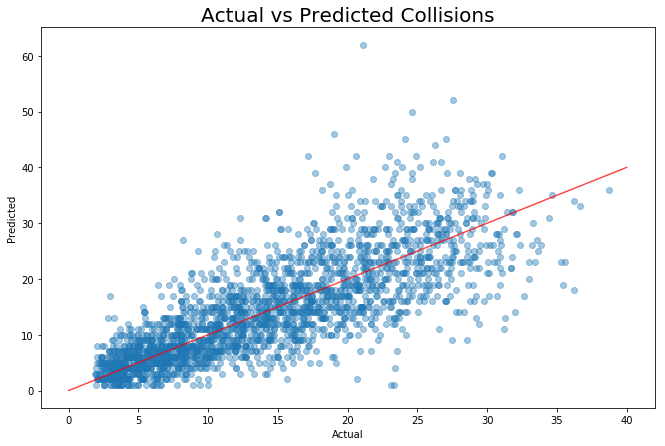

In [21]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Collisions', fontsize=20)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_data.preds, test_data.collisions, alpha=.4)
plt.plot([0, 40], [0, 40], 'red', alpha=0.7)
grid.score(test_features, test_outcomes)

In predicting the test data, our model is able to capture the trend but is unable to get an accuracte representation of the exact daily number of collisions as shown by the variance from the data points around the line. The predicted values are often over predicting, which we notice from the slope of the line in the regression plot. It still provides a general idea of the relative number of collisions that occur throughout.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Time series of Actual vs Predicted Collisions')

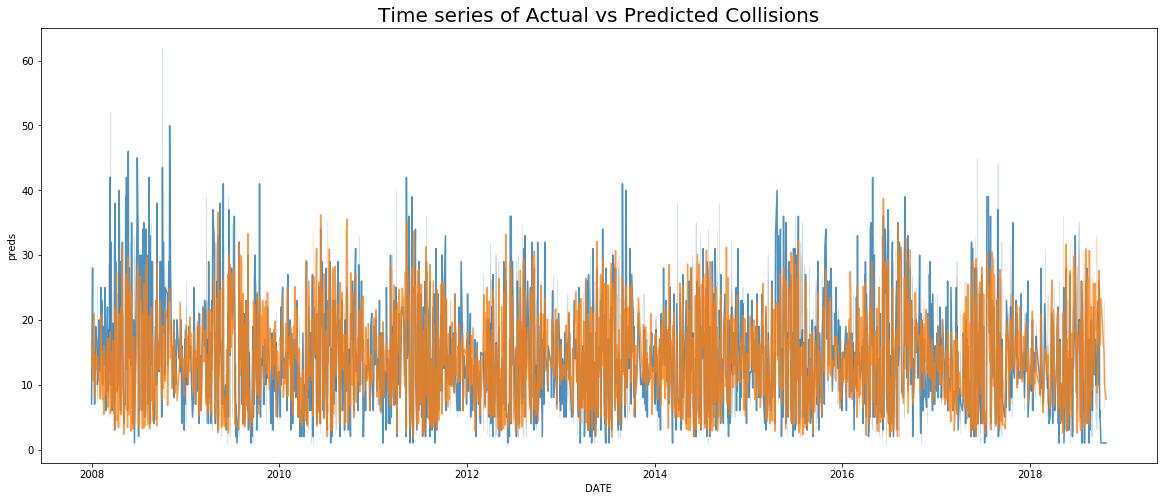

In [22]:
plt.subplots(figsize=(20,8))
sns.lineplot(x=test_data.DATE, y=test_data.collisions, data=test_data, alpha=0.8)
sns.lineplot(x=test_data.DATE, y=test_data.preds, data=test_data, alpha=0.8)
plt.title('Time series of Actual vs Predicted Collisions', fontsize=20)

As shown by the time plot, we are able to decently capture the trend in the occurence of collisions. We are hoping to use this predictive model together with forecast data to predict the number of collisions that occur within a 5 day forecast given from the user.

Text(0.5, 1.0, 'Time Series of Predicted Residuals')

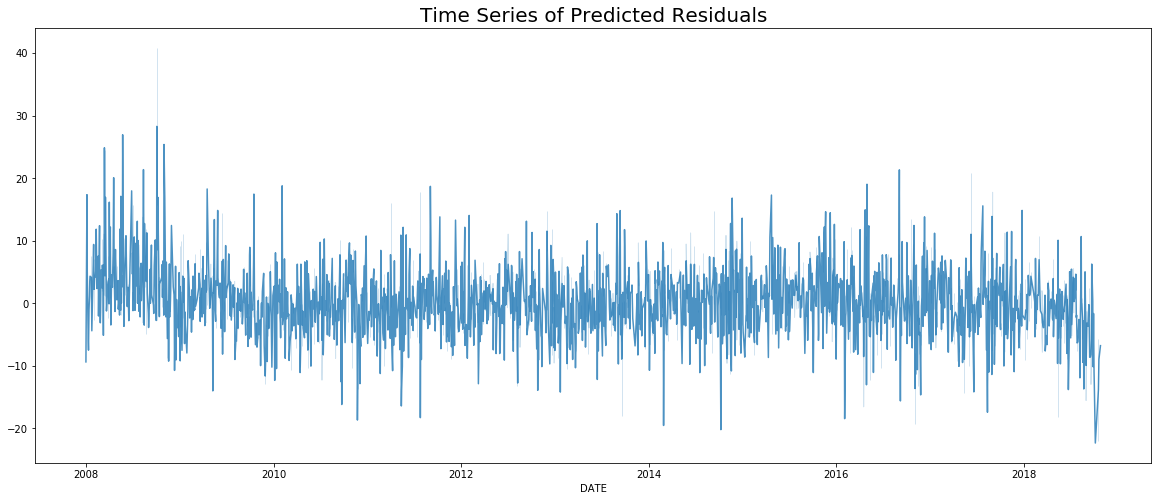

In [23]:
plt.subplots(figsize=(20,8))
sns.lineplot(x=test_data.DATE, y=test_data.collisions - test_data.preds, data=test_data, alpha=0.8)
plt.title("Time Series of Predicted Residuals", fontsize=20)

Text(0.5, 1.0, 'Predicted Residuals')

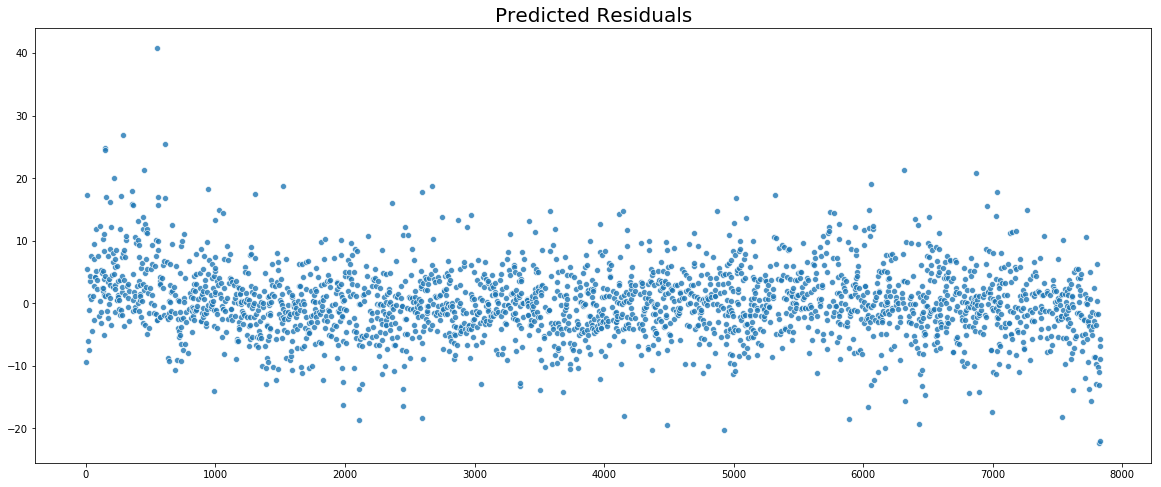

In [24]:
plt.subplots(figsize=(20,8))
sns.scatterplot(data = test_data.collisions - test_data.preds, alpha=0.8)
plt.title("Predicted Residuals", fontsize=20)

As shown the residuals are scattered evenly, showing that our predictions are generally on the spot in terms of capturing the trend that occurs with seattle collisions. There seems to be a large underprediction between 2008 and 2009, which is an outlier. The slightly higher number of collisions could be during the global financial crisis that occurs in 2008.

# Future Prediction

We created a function to generate the test dataset based on four parameters (Precipitation, Max Temperature, Min Temperature and Datetime). The above model is used to predict the number of collisions based on the given parameters.

In [40]:
from weather import Weather, Unit

# accepts latitude, longitude and date in format of dd mmm yyyy e.g. 05 Dec 2018 and returns the weather condition
def get_weather(date):
    weather = Weather(unit=Unit.FAHRENHEIT)
    lookup = weather.lookup_by_location("seattle")
    condition = lookup.condition
    forecasts = lookup.forecast
    for forecast in forecasts:
        if (forecast.date == date):
            print([forecast.text, int(forecast.high), int(forecast.low)])
            return [forecast.text, int(forecast.high), int(forecast.low)]

In [42]:
forecast = get_weather('05 Dec 2018')
TMAX = forecast[1]
TMIN = forecast[2]

['Sunny', 45, 33]


In [43]:
# predicting collisions by calling function. Parameters: Precipitation, Temp Max, Temp Min, Datetime
features = fn.predict_collisions(0, TMAX, TMIN, datetime.datetime.now())
print('Predicted Number of Collisions:', grid.predict(features).astype(int))

Predicted Number of Collisions: [15]
